#### Dependencies

uncomment the cell below and run it to install the project dependencies

In [1]:
#!pip install numpy pandas seaborn pillow matplotlib scikit-learn keras

#### Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import PIL.Image as Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import keras.datasets.mnist as mnist # use only to retrieve data

#### Retrieve data

We retrieve data from keras hub

In [3]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
(train_X.shape, train_y.shape), (test_X.shape, test_y.shape) # check dimensions

(((60000, 28, 28), (60000,)), ((10000, 28, 28), (10000,)))

#### Preprocessing: customize dataset

In [4]:
class PreprocessingData:
    """
        Class for preprocessing data and generating batch iterations.
    """

    def __init__(self, X, y, batch_size, transf=None):
        """
            Initializes the PreprocessingData class with input data, labels, and batch size.
        """
        X, y = X.reshape(-1, 28*28).T, y.reshape(-1, 1).T
        # suffle data
        permutation = list(np.random.permutation(X.shape[1]))
        self.X = X[:, permutation]
        self.y = y[:, permutation].reshape(-1, X.shape[1])
        self.batch_size = min(batch_size, X.shape[1])  # if batch_size > length
        self.transf = transf
        self.length = X.shape[1]

    def __getitem__(self, index):
        """
            Returns a specific batch based on the index.
        """
        X_batch = self.X[:, index]
        y_batch = self.y[:, index]
        batch = X_batch, y_batch

        if self.transf:
            batch_transf = self.transf(batch)
            return batch_transf
        return batch

    def __len__(self):
        """
            Returns the total length of the data.
        """
        return self.length

    def batch_iterator(self):
        """
            Generates data batches by iterating over the entire dataset.
        """
        if self.batch_size >= self.length:
            # Handle case where batch_size is greater than total data size
            batch = self.X, self.y
            if self.transf:
                batch_transf = self.transf(batch)
                yield batch_transf
            else:
                yield batch
        else:
            nbr_of_batches = self.length // self.batch_size

            for i in range(nbr_of_batches):
                X_batch = self.X[:, i * self.batch_size: (i + 1) * self.batch_size]
                y_batch = self.y[:, i * self.batch_size: (i + 1) * self.batch_size]
                batch = X_batch, y_batch

                if self.transf:
                    batch_transf = self.transf(batch)
                    yield batch_transf
                else:
                    yield batch

            if self.length % self.batch_size != 0:
                X_last_batch = self.X[:, nbr_of_batches * self.batch_size:]
                y_last_batch = self.y[:, nbr_of_batches * self.batch_size:]
                last_batch = X_last_batch, y_last_batch

                if self.transf:
                    last_batch_transf = self.transf(last_batch)
                    yield last_batch_transf
                else:
                    yield last_batch


###################### Transformation class ######################
class Transformation:
    """
        Class to define transformations to apply on batches.
    """

    def __init__(self, X_max, nb_classes):
        """
            Initializes the Transformation class with normalization and label conversion parameters.
        """
        self.X_max = X_max
        self.nb_classes = nb_classes

    def norm_X(self, X):
        """
            Normalizes the input data.
        """
        return X / self.X_max  

    def y_to_one_hot(self, y):
        """
            Converts label vector to matrix.
        """
        y = np.reshape(y, (-1, 1))
        Y = np.zeros((self.nb_classes, len(y)))

        for j, label in enumerate(y):
            Y[label, j] = 1

        return Y

    def __call__(self, batch):
        """
            Applies transformations on a given batch.
        """
        X, y = batch[0], batch[1]
        return self.norm_X(X), self.y_to_one_hot(y)


#### Activation functions

In [5]:
###################### activation functions ######################

def ReLU(z):
    return np.maximum(0, z)

def dReLU(z):
    return np.where(z > 0, 1, 0)

def LeakyReLU(z, alpha=0.01):
    return np.where(z > 0, z, alpha * z)

def dLeakyReLU(z, alpha=0.01):
    return np.where(z > 0, 1, alpha)

def Tanh(z):
    return np.tanh(z)

def dTanh(z):
    return 1 - np.tanh(z)**2

def Sigmoid(z):
    return 1 / (1 + np.exp(-z))

def dSigmoid(z):
    s = Sigmoid(z)
    return s * (1 - s)

def Softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

def dSoftmax(z):
    s = Softmax(z)
    return s * (1 - s)

# dictionary of activation functions
dict_activation = {
    "relu": (ReLU, dReLU),
    "leakyrelu": (LeakyReLU, dLeakyReLU),
    "tanh": (Tanh, dTanh),
    "sigmoid": (Sigmoid, dSigmoid), 
    "Softmax": (Softmax, dSoftmax)
}


###################### loss functions ######################
def binary_cross_entropy_loss(y, y_hat):
    m = y.shape[1]
    loss = -np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)) / m
    return loss

def categorical_cross_entropy_loss(y, y_hat):
    m = y.shape[1]
    epsilon = 1e-10  # numrerical stability 
    loss = -np.sum(np.sum(np.multiply(y, np.log(y_hat + epsilon)), axis=0)) / m
    return loss

def mse_loss(y, y_hat):
    return np.mean(np.square(y_hat-y))

####
#### Optimizers

In [6]:
class Optimizer:
    def __init__(self, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.momentums = {}  # Store momentums for each parameter
        self.rmsprops = {}  # Store squared gradients for each parameter
        self.t = 0  # Time step counter for Adam

    def update_parameters_SGD(self, model, learning_rate=None):
        learning_rate = learning_rate or self.learning_rate
        for key in model.parameters.keys():
            model.parameters[key] -= learning_rate * model.gradients["d" + key]

    def update_parameters_SGD_with_momentum(self, model, learning_rate=None, momentum=None):
        learning_rate = learning_rate or self.learning_rate
        momentum = momentum or self.beta1

        for key in model.parameters.keys():
            if key not in self.momentums:
                self.momentums[key] = np.zeros_like(model.parameters[key])

            self.momentums[key] = momentum * self.momentums[key] + (1 - momentum) * model.gradients["d" + key]
            model.parameters[key] -= learning_rate * self.momentums[key]

    def update_parameters_RMSProp(self, model, learning_rate=None, beta2=None, epsilon=None):
        learning_rate = learning_rate or self.learning_rate
        beta2 = beta2 or self.beta2
        epsilon = epsilon or self.epsilon

        for key in model.parameters.keys():
            if key not in self.rmsprops:
                self.rmsprops[key] = np.zeros_like(model.parameters[key])

            self.rmsprops[key] = beta2 * self.rmsprops[key] + (1 - beta2) * np.square(model.gradients["d" + key])
            model.parameters[key] -= learning_rate * (model.gradients["d" + key] / np.sqrt(self.rmsprops[key] + epsilon))

    def update_parameters_Adam(self, model, learning_rate=None, beta1=None, beta2=None, epsilon=None):
        self.t += 1
        learning_rate = learning_rate or self.learning_rate
        for key in model.parameters.keys():
            if key not in self.momentums:
                self.momentums[key] = np.zeros_like(model.parameters[key])
            if key not in self.rmsprops:
                self.rmsprops[key] = np.zeros_like(model.parameters[key])

            self.momentums[key] = self.beta1 * self.momentums[key] + (1 - self.beta1) * model.gradients["d" + key]
            self.rmsprops[key] = self.beta2 * self.rmsprops[key] + (1 - self.beta2) * np.square(model.gradients["d" + key])
            
            mnt_corrected = self.momentums[key] / (1 - self.beta1 ** self.t)
            rms_corrected = self.rmsprops[key] / (1 - self.beta2 ** self.t)
            model.parameters[key] -= learning_rate * mnt_corrected / (np.sqrt(rms_corrected) + self.epsilon)


####
#### Neural network for a classsification task

In [7]:
class NNClassifier:
    def __init__(self, layers_dims, weight_init="He", bias=True, activation_function=None):
        """
            Initializes the neural network with the specified parameters.
        """
        self.bias = bias
        self.total = 0
        self.memory = {}
        self.gradients = {}
        self.parameters = {}
        self.layers_dims = layers_dims
        self.number_of_layers = len(self.layers_dims)
        self.weight_init = weight_init
        self.initialize_weights() # initialization of parameters with "weight_init" method
        self.activation_function, self.activation_derivative = self.get_activation_functions(activation_function)

    

    def initialize_weights(self):
        """
        Initializes the weights and biases of the neural network.Three cases He, Xavier or Randomly with scale
        """
        for l in range(1, self.number_of_layers):
            previous_layer_dim, current_layer_dim = self.layers_dims[l-1], self.layers_dims[l]#layer_dim

            if self.weight_init.lower() == "he":
                scale = np.sqrt(2 / previous_layer_dim)
            elif self.weight_init.lower() == "xavier":
                scale = np.sqrt(1 / previous_layer_dim)
            else:
                scale = .001

            self.parameters["W" + str(l)] = np.random.randn(current_layer_dim, previous_layer_dim) * scale
            if self.bias:
                self.parameters["B" + str(l)] = np.zeros((current_layer_dim, 1))

    

    
    def get_activation_functions(self, activation):
        """
        get the activation function and its derivative based on the provided activation name.
        """
        activation = activation.lower() if activation else "relu"
        
        if activation not in dict_activation:
            raise ValueError(f"Invalid activation function: {activation}. Supported values: {list(dict_activation.keys())}")
    
        return dict_activation[activation]


    
    def forward(self, x):
        """
            Performs the forward pass through the neural network.
            m is number of example
        """
        self.memory["A" + str(0)] = A_previous = x
        # Hidden(s) layer(s)
        for l in range(1, self.number_of_layers - 1):
            W = self.parameters["W" + str(l)]
            if self.bias:
                B = self.parameters["B" + str(l)]
                Z = np.dot(W, A_previous) + B
            else: 
                Z = np.dot(W, A_previous)
            self.memory["Z" + str(l)] = Z
            A_current = self.activation_function(Z)
            self.memory["A" + str(l)] = A_current
            A_previous = A_current
            
        # Output layer
        W = self.parameters["W" + str(self.number_of_layers - 1)]
        if self.bias: 
            B = self.parameters["B" + str(self.number_of_layers - 1)]
            Z = np.dot(W, A_previous) + B
        else:
            Z = np.dot(W, A_previous)
        self.memory["Z" + str(self.number_of_layers - 1)] = Z
        x = Z
        return x


    
    def backward(self, X, Y, Y_proba):
        """
            Performs the backward pass (backpropagation) through the neural network to compute gradients.
        """
        m = X.shape[1]
        A = Y_proba
        dZ = 1/m * (A - Y)
        # For output layer
        self.memory["dZ" + str(self.number_of_layers - 1)] = dZ
        A_previous = self.memory["A" + str(self.number_of_layers - 2)]                         
        self.gradients["dW" + str(self.number_of_layers - 1)] = np.dot(dZ, A_previous.T) / m    
        if self.bias:
            self.gradients["dB" + str(self.number_of_layers - 1)] = np.sum(dZ, axis=1, keepdims=True) / m

        # For Hidden(s) layer(s)
        for l in reversed(range(1, self.number_of_layers - 1)):
            W_next = self.parameters["W" + str(l + 1)]
            dZ_next = self.memory["dZ" + str(l + 1)]
            Z_current = self.memory["Z" + str(l)]
            A_previous = self.memory["A" + str(l - 1)]
            dZ_current = np.multiply(np.dot(W_next.T, dZ_next), np.vectorize(self.activation_derivative)(Z_current))
            self.gradients["dW" + str(l)] = np.dot(dZ_current, A_previous.T) / m 
            if self.bias:
                self.gradients["dB" + str(l)] = np.sum(dZ_current, axis=1, keepdims=True) / m
            self.memory["dZ" + str(l)] = dZ_current

        return self.gradients



    def total_parameters(self):
        """
        Calculates the total number of parameters in the neural network.
        """
        self.total = 0
        for i in range(1, self.number_of_layers):
            if self.bias:
                self.total += self.layers_dims[i] * (self.layers_dims[i - 1] + 1)
            else:
                self.total += self.layers_dims[i] * (self.layers_dims[i - 1])
        return self.total
        

    def predict(self, x):
        """
        Makes class predictions using the trained neural network.
        """
        return np.argmax(self.proba(x), axis=0)


    def proba(self, x):
        """
        Computes the class probabilities using the trained neural network.
        """
        A = x
        # Hidden layer(s)
        for l in range(1, self.number_of_layers - 1):
            W = self.parameters["W" + str(l)]
            if self.bias:
                B = self.parameters["B" + str(l)]
                x = self.activation_function(np.dot(W, x) + B)
            else:
                 x = self.activation_function(np.dot(W, x))
                
        # Output layer
        W = self.parameters["W" + str(self.number_of_layers - 1)]
        if self.bias:
            B = self.parameters["B" + str(self.number_of_layers - 1)]
            out = np.dot(W, x) + B
        else:
            out = np.dot(W, x) 
            
        return Softmax(out)



    def check_gradient(self):
        """
        Placeholder for a method that could be used to check gradients.
        """
        pass

    def __call__(self, x):
        """
        Makes the object callable, allowing for convenient use like a function.
        """
        return self.forward(x)

    def __repr__(self):
        """
        Returns a string representation of the neural network object.
        """
        layer_info = ""
        for i in range(1, self.number_of_layers - 1):
            layer_info += f"\n\tLayer {i}: Linear(in_dim={self.layers_dims[i-1]}, out_dim={self.layers_dims[i]}, bias={self.bias})\
            \n\tActivation function: {self.activation_function.__name__}()"

        return f"NN model with {self.number_of_layers} layers of which {self.number_of_layers - 2} hidden layer\
       \n\n\t(Input layer): (Layer 0 : (dim={self.layers_dims[0]})\
       \n\t(Hidden layers): ({layer_info})\
       \n\t(Output layer): (Layer {self.number_of_layers - 1} Linear(in_dim={self.layers_dims[-2]}, out_dim={self.layers_dims[-1]}, bias={self.bias})"

    def __str__(self):
        """
        Returns a string representation of the neural network object.
        """
        return self.__repr__()

####
#### Hyperparameters and instanciations

In [8]:
# hyperparameters
lr = .4
batch_size = 8
nb_iter  =  15
nb_classes = 10
input_dim = 28*28
layers_dims = [input_dim, 64, nb_classes]

# to have the same initial values at runtime
np.random.seed(3)

# data 
transf  = Transformation(255., nb_classes)
data_train = PreprocessingData(train_X, train_y, transf=transf, batch_size = batch_size)
data_dev = PreprocessingData(test_X, test_y, transf=transf, batch_size = 10000)

# criterion  and optimizer
criterion = categorical_cross_entropy_loss
optim = Optimizer()

# model
model = NNClassifier(layers_dims, weight_init="He", activation_function="relu")
print(f"{model} \n\nNumber of parameters:  {model.total_parameters()/1e6} Million(s)")

# training and dev logs
train_stuff = {"train_loss": [],
              "train_acc": []
            }
dev_stuff = {"dev_loss": [],
             "dev_acc": []
            }

NN model with 3 layers of which 1 hidden layer       

	(Input layer): (Layer 0 : (dim=784)       
	(Hidden layers): (
	Layer 1: Linear(in_dim=784, out_dim=64, bias=True)            
	Activation function: ReLU())       
	(Output layer): (Layer 2 Linear(in_dim=64, out_dim=10, bias=True) 

Number of parameters:  0.05089 Million(s)


####
#### Visualize data

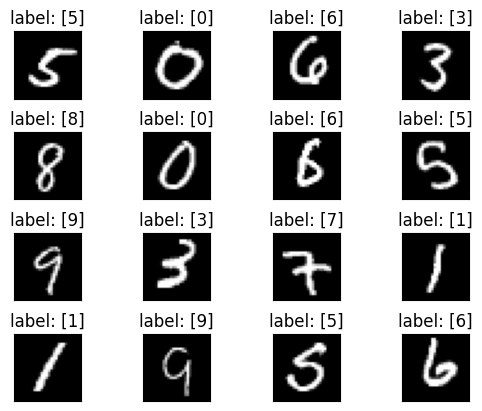

In [9]:
for i in range(16):
    image, label = data_train[i][0].reshape(28, 28), np.argmax(data_train[i][1], axis=0)
    plt.subplot(4, 4, i + 1)
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.title("label: " + str(label))

# vertical spacing
plt.subplots_adjust(hspace=0.5)

# delete axes graduations
for ax in plt.gcf().get_axes():
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

#### Training loop

In [10]:
for i in range(nb_iter):
    # Training stuff
    loss_iter = []
    y_hat_iter = []
    y_iter = []

    for X_batch, y_batch in data_train.batch_iterator():
        # step 1: Forward
        Z = model(X_batch)
        y_proba = Softmax(Z)
        # step 2: Compute loss
        loss = criterion(y_batch, y_proba)
        # step 3: Backward  
        grad = model.backward(X_batch, y_batch, y_proba)
        # step 4: update parameters
        optim.update_parameters_SGD(model, learning_rate=lr)
        # Compute accuracy
        y_hat_iter.extend(np.argmax(y_proba, axis=0))
        y_iter.extend(np.argmax(y_batch, axis=0))
        # store loss batch
        loss_iter.append(loss)


    # Calculate and store training loss and accuracy epoch
    train_loss_mean = np.mean(loss_iter)
    train_accuracy = int(round(np.sum(np.array(y_iter) == np.array(y_hat_iter)) / len(y_iter), 2) * 100)
    train_stuff["train_loss"].append(train_loss_mean)
    train_stuff["train_acc"].append(train_accuracy)

    # Validation mode: use predict or proba method to not update parameters
    X_dev, y_dev = data_dev[:]
    y_proba_dev = model.proba(X_dev) 

    # Compute validation loss and accuracy
    dev_loss = criterion(y_dev, y_proba_dev)
    dev_accuracy = int(round(np.sum(np.argmax(y_dev, axis=0) == np.argmax(y_proba_dev, axis=0)) / y_dev.shape[1] , 2) * 100)
    dev_stuff["dev_loss"].append(dev_loss)
    dev_stuff["dev_acc"].append(dev_accuracy)

    # Print progress
    print("Iter: [{}/{}]  Train loss: {:.3f} Dev loss: {:.3f} | Train acc: {}%  Dev acc: {}%".format(
        i+1, nb_iter, train_loss_mean, dev_loss, train_accuracy, dev_accuracy))


Iter: [1/15]  Train loss: 0.258 Dev loss: 0.139 | Train acc: 92%  Dev acc: 96%
Iter: [2/15]  Train loss: 0.127 Dev loss: 0.105 | Train acc: 96%  Dev acc: 97%
Iter: [3/15]  Train loss: 0.096 Dev loss: 0.094 | Train acc: 97%  Dev acc: 97%
Iter: [4/15]  Train loss: 0.078 Dev loss: 0.088 | Train acc: 98%  Dev acc: 97%
Iter: [5/15]  Train loss: 0.066 Dev loss: 0.086 | Train acc: 98%  Dev acc: 97%
Iter: [6/15]  Train loss: 0.056 Dev loss: 0.083 | Train acc: 98%  Dev acc: 98%
Iter: [7/15]  Train loss: 0.048 Dev loss: 0.084 | Train acc: 99%  Dev acc: 97%
Iter: [8/15]  Train loss: 0.040 Dev loss: 0.085 | Train acc: 99%  Dev acc: 97%
Iter: [9/15]  Train loss: 0.035 Dev loss: 0.085 | Train acc: 99%  Dev acc: 97%
Iter: [10/15]  Train loss: 0.030 Dev loss: 0.086 | Train acc: 99%  Dev acc: 98%
Iter: [11/15]  Train loss: 0.025 Dev loss: 0.089 | Train acc: 99%  Dev acc: 97%
Iter: [12/15]  Train loss: 0.022 Dev loss: 0.091 | Train acc: 99%  Dev acc: 98%
Iter: [13/15]  Train loss: 0.019 Dev loss: 0.094 

#### Visualize training logs

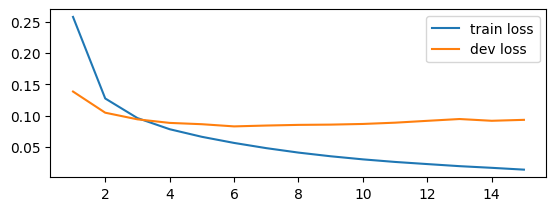

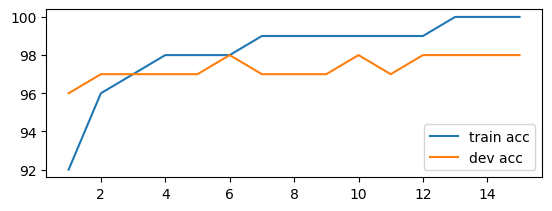

In [11]:
plt.subplot(211)
plt.plot(range(1,nb_iter+1), train_stuff["train_loss"], label="train loss")
plt.plot(range(1,nb_iter+1), dev_stuff["dev_loss"], label="dev loss")
plt.legend()
plt.show()
plt.subplot(212)
plt.plot(range(1,nb_iter+1), train_stuff["train_acc"], label="train acc")
plt.plot(range(1,nb_iter+1), dev_stuff["dev_acc"], label="dev acc")
plt.legend()
plt.show()

####
#### Evaluation

In [12]:
X_dev, y_dev = data_dev[:] 
true_labels  = np.argmax(y_dev, axis=0).reshape(-1)
labels_pred  = model.predict(X_dev).reshape(-1)
total_error = (true_labels!=labels_pred).sum()
print(f"\nTotal error: {total_error}/{len(true_labels)}\t ||\tAccuracy: {1 - (total_error/len(true_labels)):.3f}%\n")


Total error: 228/10000	 ||	Accuracy: 0.977%



####
#### Plotting results

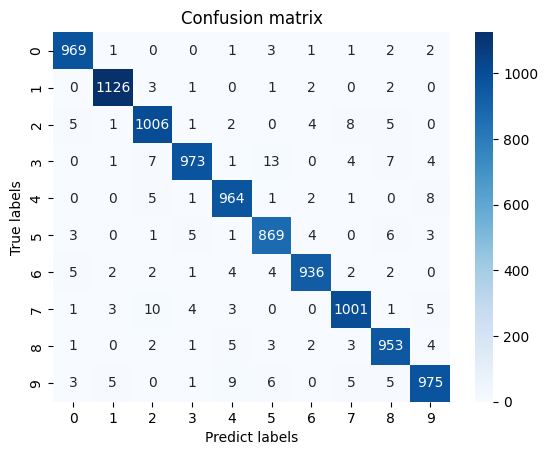


Total error: 228/10000



In [13]:
cfm = confusion_matrix(true_labels, labels_pred)
sns.heatmap(cfm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predict labels')
plt.ylabel('True labels')
plt.show()
print(f"\nTotal error: {total_error}/{len(true_labels)}\n")

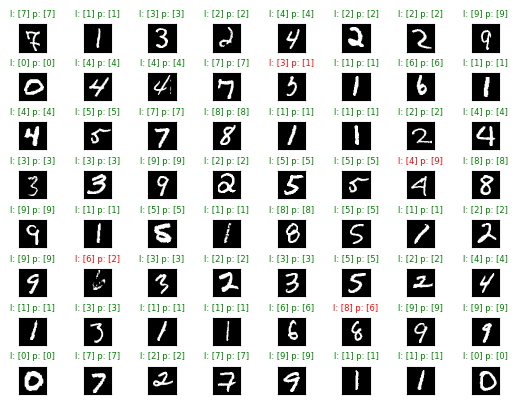

In [14]:
for i in range(64):
    j = np.random.randint(0, 10000) # for choose image randomly
    # choose and resize for plotting
    image, label = data_dev[j][0].reshape(28, 28), np.argmax(data_dev[j][1], axis=0) 
    pred_label  = model.predict(image.reshape(-1,1)).reshape(-1)
    # plotting
    plt.subplot(8, 8, i + 1)
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    color = "green" if pred_label == label else "red"
    title = "l: " + str(label) + " p: " + str(pred_label)
    plt.title(title, color=color, fontsize=6)

# vertical spacing
plt.subplots_adjust(hspace=0.8)
plt.subplots_adjust(wspace=0.5)
# delete axes graduations
for ax in plt.gcf().get_axes():
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()